# Homework 4 :


In [134]:
import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML 

from IPython.display import display, Math, Latex


# I - Guidelines

We want to predict a category, i.e. the skin color of the player. Let's figure out what to do following the diagram below, from scikit-learn. 

In [12]:
Image(url= "http://scikit-learn.org/stable/_static/ml_map.png", width=700)

# II - The Data
Let's take a look at the data and already drop what is not useful for the predictions.

In [119]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

In [120]:
df = df[['height','weight', 'position','games','victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards','rater1', 'rater2','refNum','refCountry', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp']] # considering birthday (age) is not useful because we don't have the dates of individual matches
df.head(3)

,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,...,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,...,0.25,0.50,1,1,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,179.0,82.0,Right Winger,1,0,0,1,0,1,0,...,0.75,0.75,2,2,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,181.0,79.0,NaN,1,0,1,0,0,1,0,...,NaN,NaN,3,3,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [121]:
df.position.unique()  # We have to replace this with numerical values, as we do with the mapping below. 

array(['Attacking Midfielder', 'Right Winger', nan, 'Center Back',
       'Right Midfielder', 'Left Fullback', 'Defensive Midfielder',
       'Goalkeeper', 'Right Fullback', 'Left Winger', 'Left Midfielder',
       'Center Forward', 'Center Midfielder'], dtype=object)

The prediction of the skin color is checked with rater1 and rater2. We chose to drop the NaN data in the raters and choose only the data on which they agree. 

Notice that for a Random Forest classifier, there is no need to normalize the features, as no comparison is made between their magnitudes.

In [193]:
df = df[pd.notnull(df['rater1'])]
df = df[pd.notnull(df['rater2'])]


df2 = df[df.rater1 == df.rater2]
df2['rater1'] = df2['rater1']*4  # the classifier only deals with integers
df2['meanIAT'] = df2['meanIAT']*1000  # the classifier only deals with integers
df2['meanExp'] = df2['meanExp']*100  # the classifier only deals with integers
df2['seIAT'] = df2['seIAT']*10000  # the classifier only deals with integers
df2['seExp'] = df2['seExp']*10000  # the classifier only deals with integers

df2 = np.round(df2,0) # the classifier only deals with integers

df2['position'] = df2['position'].map({'Goalkeeper':0, 'Attacking Midfielder':1, 'Right Winger':2, 'Left Winger':2,
       'Center Back':3, 'Left Fullback':4,'Right Fullback':4, 'Defensive Midfielder':5, 'Left Midfielder':6,
       'Right Midfielder':6,'Center Midfielder':7,'Center Forward':8}) # notice I've used symmetry between R and L


# remember goalkeepers are less likely to get a card. Not taken into account yet

df2.drop('rater2', axis=1, inplace=True)  

df2 = df2.dropna(how='any') # dropping NaN

df2 = df2[(df2 > 0).all(1)]  # dropping negative values

df3 = df2
len(df2)

C:\Users\mariele\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mariele\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mariele\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

6

We see that we have labeled data, this means we can use a classification algorithm. Moreover, with *less* than 100K sample, we can use [Linear Support Vector Classification](https://en.wikipedia.org/wiki/Support_vector_machine). Now, for the moment, let's suppose it won't work, neither K-Neighbors Classifiers. Let's directly move to Ensemble Classifiers as asked in the HW assignment.

In [194]:
df2.head()

,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
25206,182.0,78.0,8.0,18,7,6,5,9,6,1,1,1.0,468,3,370.0,1785.0,2.0,59.0,1897.0,10.0
43504,181.0,77.0,5.0,23,9,8,6,1,7,1,1,1.0,804,3,370.0,1785.0,2.0,59.0,1897.0,10.0
96590,181.0,77.0,5.0,21,7,5,9,1,9,1,1,1.0,2073,3,370.0,1785.0,2.0,59.0,1897.0,10.0
105437,184.0,82.0,3.0,8,4,1,3,1,2,1,1,2.0,2266,49,379.0,1038.0,4.0,63.0,1158.0,21.0
112638,179.0,71.0,4.0,13,3,4,6,1,2,1,1,1.0,2385,8,337.0,7749.0,1.0,34.0,7974.0,2.0


In [163]:
df2.columns

Index(['height', 'weight', 'position', 'games', 'victories', 'ties', 'defeats',
       'goals', 'yellowCards', 'yellowReds', 'redCards', 'refNum',
       'refCountry', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'],
      dtype='object')

#  III - Machine Learning

Selecting the attributes and passing as X for scikit

In [195]:
y = df3.rater1

df3.drop('rater1', axis=1, inplace=True)  
X = df3
X.head()

,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
25206,182.0,78.0,8.0,18,7,6,5,9,6,1,1,468,3,370.0,1785.0,2.0,59.0,1897.0,10.0
43504,181.0,77.0,5.0,23,9,8,6,1,7,1,1,804,3,370.0,1785.0,2.0,59.0,1897.0,10.0
96590,181.0,77.0,5.0,21,7,5,9,1,9,1,1,2073,3,370.0,1785.0,2.0,59.0,1897.0,10.0
105437,184.0,82.0,3.0,8,4,1,3,1,2,1,1,2266,49,379.0,1038.0,4.0,63.0,1158.0,21.0
112638,179.0,71.0,4.0,13,3,4,6,1,2,1,1,2385,8,337.0,7749.0,1.0,34.0,7974.0,2.0


In [157]:
y.head()

1     3.0
7     4.0
8     1.0
9     0.0
10    0.0
Name: rater1, dtype: float64

## I - Feature Selection

Some tips on this can be found [here](https://www.quora.com/How-do-I-perform-feature-selection). For the moment, I'm gonna follow the more explicit and concise suggestions from [here](http://machinelearningmastery.com/feature-selection-machine-learning-python/), whose generalities are presented [here](http://machinelearningmastery.com/an-introduction-to-feature-selection/).

The bottom line here is that we should do feature selection in a different datase than the training dataset, otherwise we might overfit the data.

What about _cross-validation_? According to the [last link above](http://machinelearningmastery.com/an-introduction-to-feature-selection/), one should include feature selection within the inner-loop, i.e. feature selection should be performed on the prepared fold _right_ before the model is trained. Performing model selection and training on the selected features would generate biased results. It might occur that one model is enhanced by the selected feature and this model will get get better results, but that is just to an introduced bias. In other words,  *"when performing feature selection on all the data and then cross-validate, the test data in each fold of the CV procedure was also used to choose the features and this is what biases the performance analysis"*.

## 1) Univariate Selection

Select the $n$ better features after a $\chi^2$ test.

SelectKBest(score_func=chi2, k=n)

In [206]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X,y)
# summarize scores
np.set_printoptions(precision=2)
print(fit.scores_)
print(X.columns)
features = fit.transform(X)
# summarize selected features
#print(features[0:5,:])

[  1.06e-01   5.07e-01   1.79e+00   5.56e+00   8.33e-01   3.98e+00
   1.83e+00   2.29e+00   2.80e+00   0.00e+00   0.00e+00   9.69e+02
   1.34e+02   2.77e+00   1.41e+03   1.88e+00   8.66e+00   1.37e+03
   1.55e+01]
Index(['height', 'weight', 'position', 'games', 'victories', 'ties', 'defeats',
       'goals', 'yellowCards', 'yellowReds', 'redCards', 'refNum',
       'refCountry', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'],
      dtype='object')


## 2) Recursive Feature Elimination with Logistic Regression


maybe this one does not make sense here... why?

In [212]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [ True False False False False False False False False False False False
  True  True False False  True False False]
Feature Ranking: [ 1  3 10  6 11 12  9 14  8 16 15  2  1  1  5 13  1  4  7]


## 3) Principal Component Analysis

In [214]:
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=3)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [  9.44e-01   5.62e-02   3.11e-05]
[[ -3.57e-04  -9.00e-04  -1.15e-04  -3.61e-04  -3.81e-04  -5.78e-05
    7.72e-05  -2.07e-04  -3.88e-04   0.00e+00   0.00e+00   1.03e-01
   -1.25e-03  -4.12e-03   6.97e-01  -1.91e-04  -3.01e-03   7.09e-01
   -1.34e-03]
 [  1.39e-03   9.04e-05  -1.81e-03  -2.79e-03  -1.14e-03  -1.98e-03
    3.33e-04  -2.49e-03  -1.03e-03   0.00e+00   0.00e+00   9.95e-01
    9.78e-03  -6.21e-03  -7.36e-02   4.24e-04  -4.86e-03  -7.17e-02
    1.37e-03]
 [  1.08e-02  -9.33e-02   1.50e-02   2.00e-01   5.90e-02   6.57e-02
    7.58e-02   7.81e-03   7.51e-02   0.00e+00   0.00e+00   4.39e-03
   -7.30e-01  -4.48e-01   2.04e-01  -2.86e-02  -2.73e-01  -2.06e-01
   -1.97e-01]]


## Splitting into training and testing data

In [129]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [130]:
# default split is 75% for training and 25% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(71785, 3)
(71785,)
(23929, 3)
(23929,)


In [131]:
from sklearn.ensemble import RandomForestClassifier

In [132]:
# instantiate
rf = RandomForestClassifier()

# fit the model to the training data (learn the coefficients)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
# print the intercept and coefficients
print(rf.intercept_)
print(rf.coef_)

AttributeError: 'RandomForestClassifier' object has no attribute 'intercept_'

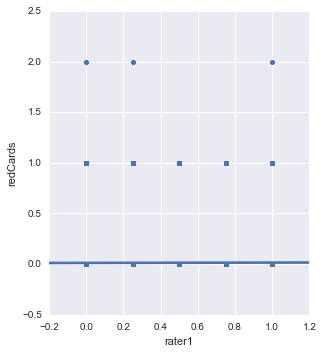

In [42]:
import seaborn as sns
# allow plots to appear within the notebook
%matplotlib inline

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df3, x_vars=['rater1'], y_vars='redCards', size=5, aspect=0.9, kind='reg')